<a href="https://colab.research.google.com/github/fellowship/platform-demos3/blob/master/OLTR/food101_oltr_fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Introduction 



In this notebook we trained long tail distributed food 101 dataset using fastai library. The purpose to do this is, to comapare the fastai results with OLTR research project results in further steps.  

### Get the data for food-101 dataset

In [1]:
!wget -nc http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz  

--2019-07-25 04:18:54--  http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.162
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz [following]
--2019-07-25 04:18:54--  https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4996278331 (4.7G) [application/x-gzip]
Saving to: ‘food-101.tar.gz’

food-101.tar.gz     100%[===================>]   4.65G  20.4MB/s    in 4m 12s  

2019-07-25 04:23:06 (18.9 MB/s) - ‘food-101.tar.gz’ saved [4996278331/4996278331]



In [0]:
!tar -xzf food-101.tar.gz

### Loading required libraries

In [3]:
# Setting up fastai in colab
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
# Notebook magic commands
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
#Import required fastai libraries
import fastai
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
print(fastai.__version__)

In [5]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


###Download data from drive to colab
This has the text documents which contains long tail distributed filenames with class information.

In [0]:
# Copying the tar file to colab memory
!cp 'drive/My Drive/Food101_LT_20.tar.gz' '/content'

In [0]:
# Untar the tar files
!tar -zxf /content/Food101_LT_20.tar.gz -C /content

In [0]:
# Remove all the tar files
!rm -rf /content/*.tar*

### EDA

Filter the images to convert balanced food dataset into long tail distributed dataset 

In [10]:
img_path = []
labels = []
is_valid = []
# root = 'drive/My Drive/food101/'

train_txt = '/content/Food101_LT/Food101_LT_train.txt'
valid_txt = '/content/Food101_LT/Food101_LT_val.txt'

with open(train_txt) as f:
  for line in f:
    img_path.append(os.path.join( line.split()[0]))
    labels.append(int(line.split()[1]))
    is_valid.append('train')
with open(valid_txt) as f:
  for line in f:
    img_path.append(os.path.join( line.split()[0]))
    labels.append(int(line.split()[1])) 
    is_valid.append('valid')
#creating a dataframe

datadit = {'ImagePath' : img_path , 'Labels' : labels , 'Train/Valid': is_valid}


df = pd.DataFrame(datadit)

df.head()

,ImagePath,Labels,Train/Valid
0,apple_pie/1005649.jpg,0,train
1,apple_pie/1014775.jpg,0,train
2,apple_pie/1026328.jpg,0,train
3,apple_pie/1028787.jpg,0,train
4,apple_pie/1043283.jpg,0,train


In [0]:
df['is_valid'] = df['Train/Valid'].str.contains('valid')

In [12]:
df.tail()

,ImagePath,Labels,Train/Valid,is_valid
7545,waffles/43069.jpg,100,valid,True
7546,waffles/435303.jpg,100,valid,True
7547,waffles/435805.jpg,100,valid,True
7548,waffles/438277.jpg,100,valid,True
7549,waffles/439439.jpg,100,valid,True


In [0]:
df = df.drop(['Train/Valid'], axis=1)

In [35]:
df['Labels'].value_counts()

0     650
1     344
2     258
3     231
4     198
5     179
6     166
7     154
8     146
9     143
10    135
11    125
12    119
13    115
14    108
15    101
16     95
17     92
18     89
19     87
20     86
21     84
22     81
23     79
24     78
25     75
26     73
27     73
28     71
29     70
     ... 
99     40
61     40
82     40
91     40
87     40
83     40
79     40
75     40
71     40
67     40
63     40
98     40
94     40
90     40
86     40
78     40
65     40
74     40
70     40
66     40
62     40
95     40
93     40
89     40
85     40
81     40
77     40
73     40
69     40
97     40
Name: Labels, Length: 101, dtype: int64

In [0]:
root = Path('/content/food-101/images/')

In [0]:
bs = 16
img_size = 224
src = (ImageList.from_df(df, root)
                 .split_from_df()).label_from_df(cols=1)
data = (src.transform(get_transforms(), size=img_size)
        .databunch(bs=bs)
        .normalize(imagenet_stats)
)

In [16]:
data

ImageDataBunch;

Train: LabelList (5120 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,0,0,0,0
Path: /content/food-101/images;

Valid: LabelList (2430 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,0,0,0,0
Path: /content/food-101/images;

Test: None

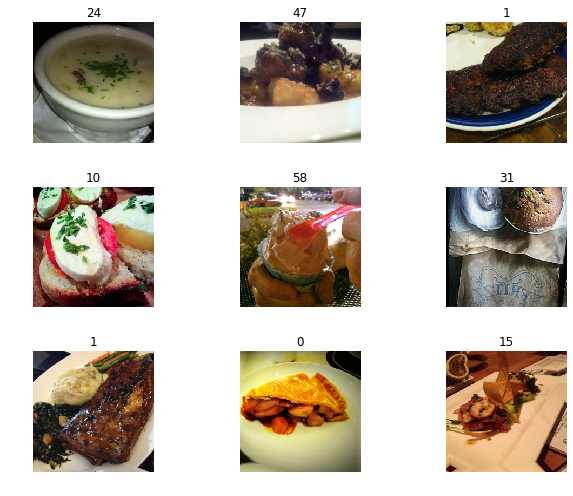

In [17]:
# show me sample images from dataset
data.show_batch(rows=3, figsize=(9, 7))

In [0]:
data.classes

###CNN learner

In [18]:
learn = cnn_learner(data, models.resnet152, metrics=[accuracy,top_k_accuracy])

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth
100%|██████████| 241530880/241530880 [00:02<00:00, 102592051.83it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


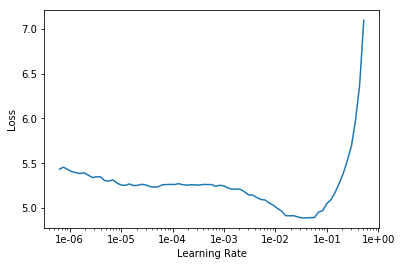

In [19]:
# Step 1: freeze and find learning rate

learn.lr_find()
learn.recorder.plot()

In [20]:
# using Cycle policy in super-convergence method, we fit using lr
# obtained from above result for 5 epochs

lr = 1e-3
learn.fit_one_cycle(5, slice(lr),callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', name='food_resn152_stg1')])

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,3.466607,3.205629,0.285185,0.525103,04:24
1,2.566638,2.425386,0.422222,0.697531,04:17
2,1.939034,2.102846,0.474486,0.753909,04:17
3,1.598086,2.000889,0.496296,0.777366,04:18
4,1.375033,1.966918,0.506584,0.779835,04:19


Better model found at epoch 0 with accuracy value: 0.28518518805503845.
Better model found at epoch 1 with accuracy value: 0.42222222685813904.
Better model found at epoch 2 with accuracy value: 0.4744856059551239.
Better model found at epoch 3 with accuracy value: 0.4962962865829468.
Better model found at epoch 4 with accuracy value: 0.5065843462944031.


In [21]:
learn.fit_one_cycle(5, slice(lr),callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', name='food_resn152_stg1')])

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.375818,1.950280,0.518519,0.777778,04:18
1,1.571672,1.917271,0.509053,0.782305,04:17
2,1.438356,1.863435,0.530453,0.794239,04:18
3,1.138993,1.813229,0.553086,0.801235,04:18
4,0.960267,1.802961,0.547737,0.802469,04:17


Better model found at epoch 0 with accuracy value: 0.5185185074806213.
Better model found at epoch 2 with accuracy value: 0.5304526686668396.
Better model found at epoch 3 with accuracy value: 0.5530864000320435.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-06
Min loss divided by 10: 3.98E-07


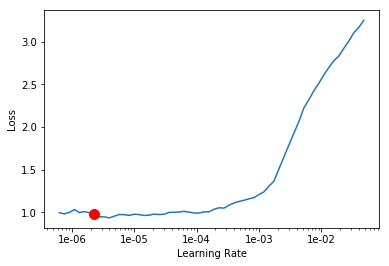

In [22]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [23]:
# lr = 1e-04
learn.fit_one_cycle(10, slice(1e-05,1e-04), callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', name='food_resn152_stg2')])

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.912646,1.773498,0.553909,0.807407,05:37
1,0.968173,1.771850,0.562551,0.807819,05:37
2,0.860888,1.751463,0.565021,0.816461,05:38
3,0.749745,1.703420,0.584362,0.823457,05:39
4,0.564267,1.674044,0.592593,0.823045,05:36
5,0.451790,1.654560,0.590123,0.833333,05:38
6,0.332871,1.643753,0.602469,0.831276,05:38
7,0.242574,1.635354,0.601646,0.833745,05:38
8,0.219126,1.666358,0.594239,0.832922,05:37
9,0.204499,1.636120,0.605350,0.837037,05:38


Better model found at epoch 0 with accuracy value: 0.5539094805717468.
Better model found at epoch 1 with accuracy value: 0.5625514388084412.
Better model found at epoch 2 with accuracy value: 0.5650205612182617.
Better model found at epoch 3 with accuracy value: 0.5843621492385864.
Better model found at epoch 4 with accuracy value: 0.5925925970077515.
Better model found at epoch 6 with accuracy value: 0.6024691462516785.
Better model found at epoch 9 with accuracy value: 0.6053497791290283.


In [24]:
lr = 1e-04
learn.fit_one_cycle(5, slice(lr), callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', name='food_resn152_stg2-1')])

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.194304,1.647253,0.603292,0.835802,05:39
1,0.207646,1.640877,0.602058,0.832922,05:39
2,0.180799,1.656492,0.602469,0.832922,05:39
3,0.149117,1.666820,0.607407,0.832099,05:43
4,0.131729,1.662786,0.605761,0.834568,05:41


Better model found at epoch 0 with accuracy value: 0.6032921671867371.
Better model found at epoch 3 with accuracy value: 0.6074073910713196.


The accuracy is saturated at this point. So stopped training further.

In [0]:
learn.load('food_resn152_stg2-1')

In [0]:
learn.export('food_resn152.pkl')

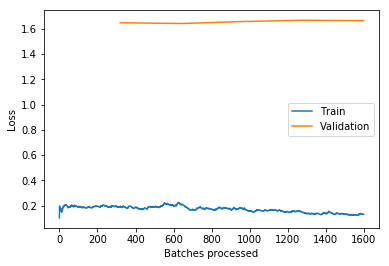

In [26]:
learn.recorder.plot_losses()

In [0]:
# interp = ClassificationInterpretation.from_learner(learn)
# interp.plot_confusion_matrix(figsize=(5, 5), dpi=100)

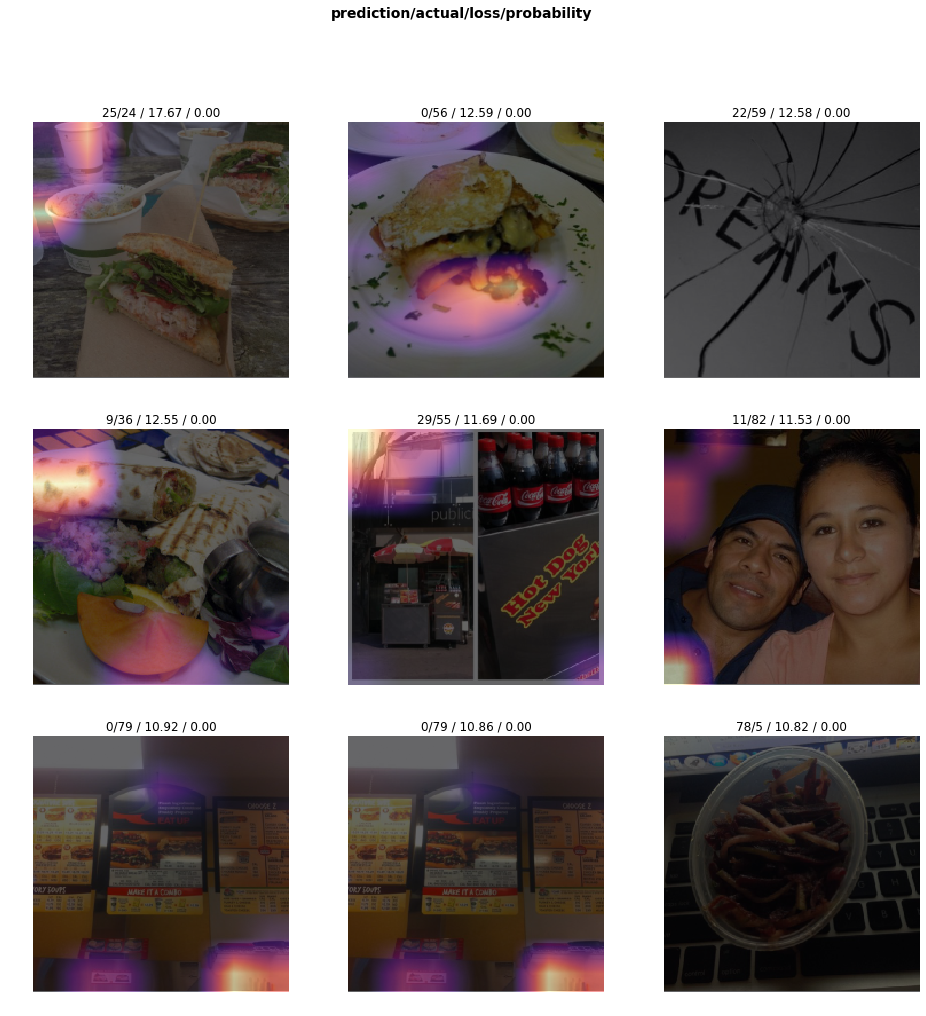

In [28]:
interp.plot_top_losses(9, figsize=(16,16))

In [31]:
interp.most_confused(min_val=4)

[(8, 0, 9),
 (99, 4, 8),
 (0, 2, 6),
 (22, 21, 6),
 (78, 40, 6),
 (93, 1, 6),
 (0, 8, 5),
 (2, 0, 5),
 (49, 0, 5),
 (52, 0, 5),
 (96, 9, 5),
 (100, 8, 5),
 (36, 9, 4),
 (39, 5, 4),
 (58, 0, 4),
 (60, 24, 4),
 (72, 0, 4),
 (73, 16, 4),
 (77, 93, 4),
 (94, 0, 4),
 (98, 22, 4)]

### hooks to get activations of the penultimate layer

In [0]:
from fastai.callbacks.hooks import *
from fastai import *

# stolen from another notebook: Return activations of the penultimate layer after forward pass of an image through CNN
def get_activations(m, x):
  xb,_ = data.one_item(x)
  xb_im = Image(data.denorm(xb)[0])
  xb = xb.cuda()
  with hook_output(m[0]) as hook_a: 
      preds = m(xb)
  acts  = hook_a.stored[0].cpu()
  return acts

In [33]:
sub_ds = data.train_ds

x_new = []
m = learn.model.eval()
for idx in range(len(sub_ds)):
  x = sub_ds[idx][0]
  y = sub_ds[idx][1]
  x_new.append(get_activations(m, x).mean(1).mean(1).flatten())
    
  
    
new_dims = len(x_new[0])
print(f'Dimensions of the activations (penultimate layer): {new_dims}')

Dimensions of the activations (penultimate layer): 2048


In [0]:
!cp '/content/food-101/images/models/food_resn152_stg2-1.pth' 'drive/My Drive/'
!cp '/content/food-101/images/food_resn152.pkl' 'drive/My Drive/'